<a href="https://colab.research.google.com/github/osavelyev/sber/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_1_%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style="text-align: center;"><b>Семинар 1. PyTorch. Первая нейронная сеть. </b></h2>


In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

Наш курс является максимально практическим, поэтому мы сразу начнем с обучения нейронной сети для классификации точек в двумерном пространстве. 

# Первая нейронная сеть

### Получение данных

Нам нужно будет тренироваться на каких-то данных. Возьмем очень простой двумерный датасет, который умеет генерировать sklearn. Это нужно для того, чтобы вы смогли поиграться с архитектурой нейронной сети и посмотреть на визуализацию границ классов. Мы увидим, что чем сложнее сеть, тем более сложной получается граница и тем больше в ней шума.

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка датасета

В PyTorch датасетом называется любой объект, у которого определены два метода: \_\_len\_\_ и \_\_getitem\_\_. То есть любой объект, к которому можно применить ```len(obj_name)``` и ```obj_name[i]```. Обычный numpy массив попадает под это определение. Но мы не можем использовать его напрямую как датасет, так как у нас отдельные массивы для признаков (x) и лейблов(y). Объединить датафреймы в удобное представление нам поможет TensorDataset класс.

In [ ]:
X_train

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])

In [ ]:
# Переведем массивы в тензоры, с которыми умеет работать PyTorch. При использовании torch.from_numpy(np_ar)
# torch создает тензор полностью аналогичный numpy массиву (как по данным, так и по типу данных).
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train)
X_val = torch.from_numpy(X_val.astype(np.float32))
y_val = torch.from_numpy(y_val)

In [ ]:
X_train

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])

In [ ]:
# Используем упомянутый выше TensotDataset
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

In [ ]:
# Посмотрим, что мы действительно можем вызвать len и обратиться к элементу датасета чреез скобки []
len(train_ds)

7500

In [ ]:
# Нам возвращается tuple из признаков и лейбла: (x_features, y)
train_ds[0]

(tensor([ 0.5020, -0.3376]), tensor(1))

Как вы помните, мы решили использовать для обучения не обычный градиентный спуск, где мы считаем градиенты относительно всего лосса, а батчевый, где мы на каждом шаге берем подмножество обучающей выборки и счиатем градиент относительно только ее.

Почти всегда мы хотим выбирать не просто случайные batch_size элементов из обучающей выборки на каждом шаге. В этом случае на некоторых элементах мы можем обучаться сильно реже, чем на остальных. Вместо случайного выбора каждого батча мы будем 

1) Случайно перемешивать весь датасет.
2) Разбивать его на последовательные куски размера batch_size
3) Итерироваться по всем этим кускам.

Один проход по всему датасету называется эпохой. В эпохах очень удобно измерять, насколько долго мы обучали нашу модель. 

**DataLoader** из PyTorch как раз разбивает датасет на батчи за нас. В него нужно передавать датасет и размер батча.

In [ ]:
BATCH_SIZE = 10

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

Теперь посмотрим на этот объект.

In [ ]:
train_dl

In [ ]:
iter(train_dl)

In [ ]:
first_batch = next(iter(train_dl))
first_batch

[tensor([[ 1.3852, -0.4959],
         [-0.6971,  0.8305],
         [ 0.4958,  0.9430],
         [ 1.9152,  0.2655],
         [ 2.0507,  0.2852],
         [-0.8076,  0.1454],
         [ 0.1794,  0.4702],
         [ 1.7106, -0.0651],
         [ 0.1703,  0.1577],
         [-0.6975,  0.7465],
         [ 0.9431,  0.5085],
         [ 0.0081,  0.1045],
         [-0.0025,  1.1511],
         [ 1.0088, -0.4014],
         [ 1.0970,  0.0588],
         [-0.4211,  0.9451],
         [ 0.3837, -0.2101],
         [ 1.0956,  0.1675],
         [ 2.0031,  0.3371],
         [ 0.0603,  0.8731],
         [-0.5451,  0.8454],
         [ 1.0196, -0.5136],
         [ 1.2393, -0.3618],
         [ 0.5462,  0.8615],
         [ 1.3241, -0.4074],
         [ 1.7767, -0.0799],
         [ 0.0839,  0.2595],
         [ 1.9511, -0.0447],
         [ 1.1090, -0.5379],
         [-0.6826,  0.7052],
         [ 1.0262, -0.5677],
         [-0.0813,  0.3420],
         [ 0.8661, -0.4185],
         [-0.2480,  1.0269],
         [ 0.3

In [ ]:
X_batch, y_batch = first_batch
print(X_batch)
print("--------------------")
print(y_batch)

tensor([[ 1.3852, -0.4959],
        [-0.6971,  0.8305],
        [ 0.4958,  0.9430],
        [ 1.9152,  0.2655],
        [ 2.0507,  0.2852],
        [-0.8076,  0.1454],
        [ 0.1794,  0.4702],
        [ 1.7106, -0.0651],
        [ 0.1703,  0.1577],
        [-0.6975,  0.7465],
        [ 0.9431,  0.5085],
        [ 0.0081,  0.1045],
        [-0.0025,  1.1511],
        [ 1.0088, -0.4014],
        [ 1.0970,  0.0588],
        [-0.4211,  0.9451],
        [ 0.3837, -0.2101],
        [ 1.0956,  0.1675],
        [ 2.0031,  0.3371],
        [ 0.0603,  0.8731],
        [-0.5451,  0.8454],
        [ 1.0196, -0.5136],
        [ 1.2393, -0.3618],
        [ 0.5462,  0.8615],
        [ 1.3241, -0.4074],
        [ 1.7767, -0.0799],
        [ 0.0839,  0.2595],
        [ 1.9511, -0.0447],
        [ 1.1090, -0.5379],
        [-0.6826,  0.7052],
        [ 1.0262, -0.5677],
        [-0.0813,  0.3420],
        [ 0.8661, -0.4185],
        [-0.2480,  1.0269],
        [ 0.3088,  0.9605],
        [-0.1585,  0

In [ ]:
X_batch.size(), y_batch.size()

(torch.Size([100, 2]), torch.Size([100]))

### Нейронная сеть

![](https://miro.medium.com/max/720/1*VHOUViL8dHGfvxCsswPv-Q.png)

Вспомним, как выглядит полносвязная (fully-connected) нейронная сеть. У данной сети будет 4 слоя (каждый набор весов - 1 слой). Слои, которые делают линейное преобразование могут называться по разному + включать в себя активацию или не включать. Возможные названия: *fully-connected* слой, *полносвязный* слой, *dense* слой, *linear* слой. В PyTorch исопльзуется название *Linear*, а сам слой применяет только линейное преобразование без нелинейности.

В PyTorch уже реализовано много плезных слоев и все они находятся в torch.nn, который мы уже испортировали ранее. Ниже - список этих слоев и лоссов.

- `nn.Linear`
- `nn.Softmax`, `nn.LogSoftmax`
- `nn.ReLU`, `nn.ELU`, `nn.LeakyReLU`
- `nn.Tanh`, `nn.Sigmoid`
- `nn.LSTM`, `nn.GRU`
- `nn.Conv1d`, `nn.Conv2d`
- `nn.MaxPool1d`, `nn.AdaptiveMaxPool1d` and others pooling
- `nn.BatchNorm1d`, `nn.BatchNorm2d`
- `nn.Dropout`
- losses: `nn.CrossEntropyLoss`, `nn.NLLLoss`, `nn.MSELoss`
- etc

Про многие мы расскажем позже в нашем курсе. Все они являются наследниками nn.Module. Про наследование от него мы тоже поговорим ниже.

Сейчас продемонстрируем, как работают слои и функции активации.

In [ ]:
# Создадим батч из 3 элементов
sample_X = torch.FloatTensor([
    [0, 1],
    [2, 3],
    [1000, -1]
])

In [ ]:
# Linear(входная размерность, выходная размерность)
dense_layer = nn.Linear(2, 4)
relu_layer = nn.ReLU()

In [ ]:
dense_layer(sample_X)

tensor([[ 3.4730e-01, -1.1439e+00, -7.3163e-01, -1.2922e+00],
        [-1.0550e+00, -2.4529e+00, -2.4278e+00, -1.3527e+00],
        [-5.1659e+02,  1.4039e+00, -6.3676e+02,  6.2141e+02]],
       grad_fn=<AddmmBackward>)

In [ ]:
relu_layer(dense_layer(sample_X))

tensor([[3.4730e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.4039e+00, 0.0000e+00, 6.2141e+02]],
       grad_fn=<ReluBackward0>)

Если нам нужно применить несколько наследников nn.Module подряд (в данном случае это слои, но могут быть и полноценные модели), то мы можем использовать nn.Sequential(список слоев, которые надо применить).

In [ ]:
HIDDEN_SIZE = 10

model = nn.Sequential(
    nn.Linear(2, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 2)
)

In [ ]:
model(sample_X)

tensor([[ 0.6449,  0.1041],
        [ 1.2131,  0.5038],
        [83.8482, 61.8091]], grad_fn=<AddmmBackward>)

### Функция потерь (лосс)

Нам нужно определить какую функцию потерь мы будем использовать. Для задачи классификации, которая стоит у нас лучше всего использовать LogLoss. Для многоклассовой классификации используется лосс nn.CrossEntropyLoss. **На вход подаются логиты без применения softmax**

!!!Обратите внимание, что мы предсказываем два числа. Мы могли бы предсказывать одно, так как у нас бинарная классификация, применять сигмоиду и получать нужную вероятность. Тогда нужно было бы использовать другой лосс BCELoss. 

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# Сделаем предсказание с помощью необученной модели на нашем искусственном батче.
random_preds = model(sample_X)

# Посмотрим на полученные логиты
random_preds

tensor([[ 0.6449,  0.1041],
        [ 1.2131,  0.5038],
        [83.8482, 61.8091]], grad_fn=<AddmmBackward>)

In [ ]:
# Попробуем применить наш лосс
sample_y = torch.LongTensor([0, 1, 1])

criterion(random_preds, sample_y)

tensor(7.8691, grad_fn=<NllLossBackward>)

In [ ]:
# Также можно посмотреть на лосс без усреднения
criterion_without_avg = nn.CrossEntropyLoss(reduction='none')
criterion_without_avg(random_preds, sample_y)

tensor([ 0.4589,  1.1094, 22.0391], grad_fn=<NllLossBackward>)

Теперь мы можем воспользоваться подсчетом градиентов, который так удобно реализован в PyTorch. Для этого мы вызываем у тезнора, состоящего из одного числа метод .backward(). Ко всем тензорам, участвовавшим в подсчете лосса добавиться частная производная лосса по этому тензору в специальный аттрибут .grad 

In [ ]:
loss = criterion(random_preds, sample_y)
loss

tensor(7.8691, grad_fn=<NllLossBackward>)

In [ ]:
print('before .backward', next(model.parameters()).grad)
loss.backward()
print('after .backward', next(model.parameters()).grad)

before .backward None
after .backward tensor([[ 0.0000e+00, -4.2075e-02],
        [ 8.5413e-02,  1.0467e-01],
        [ 2.6709e+01,  1.7143e-02],
        [-1.4950e+02,  1.4950e-01],
        [-5.1401e-02, -6.2989e-02],
        [-2.3836e-02, -2.9209e-02],
        [ 0.0000e+00, -4.2462e-02],
        [ 7.5268e+01,  4.8309e-02],
        [ 0.0000e+00,  0.0000e+00],
        [-2.5987e+01,  3.5551e-02]])


In [ ]:
print('before second .backward', next(model.parameters()).grad)
random_preds = model(sample_X)
loss = criterion(random_preds, sample_y)
loss.backward()
print('after second .backward', next(model.parameters()).grad)

before second .backward tensor([[ 0.0000e+00, -4.2075e-02],
        [ 8.5413e-02,  1.0467e-01],
        [ 2.6709e+01,  1.7143e-02],
        [-1.4950e+02,  1.4950e-01],
        [-5.1401e-02, -6.2989e-02],
        [-2.3836e-02, -2.9209e-02],
        [ 0.0000e+00, -4.2462e-02],
        [ 7.5268e+01,  4.8309e-02],
        [ 0.0000e+00,  0.0000e+00],
        [-2.5987e+01,  3.5551e-02]])
after second .backward tensor([[ 0.0000e+00, -8.4149e-02],
        [ 1.7083e-01,  2.0934e-01],
        [ 5.3418e+01,  3.4286e-02],
        [-2.9901e+02,  2.9901e-01],
        [-1.0280e-01, -1.2598e-01],
        [-4.7671e-02, -5.8419e-02],
        [ 0.0000e+00, -8.4923e-02],
        [ 1.5054e+02,  9.6618e-02],
        [ 0.0000e+00,  0.0000e+00],
        [-5.1974e+01,  7.1102e-02]])


### Оптимизатор

Теперь нам нужно выбрать оптимизатор. В PyTorch реализовано уже очень много оптимизаторов, которые доступны в torch.optim. Мы выберем самый простой оптимизатор - обычный SGD. Про другие оптимизаторы мы расскажем на следующем занятии. 

При создании мы передаем в оптимизатор *параметры* модели, это специальные тензоры, обернутые в nn.Prameter, для которых считается градиент (requires_grad=True). После при вызове .step() оптимизатор проитерируется по всем тензорам и вычетет из них градиент, умноженный на lr.

Как вы видели раньше, если вызвать .backward несколько раз, то градиент просто будет складываться. Поэтому у оптимизатороа есть удобный метод .zero_grad(), который обнуляет все градиенты.

In [ ]:
LEARNING_RATE = 3e-4
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

### Обучение


Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для классификации
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
```

В коде ниже добавлено логирование `accuracy` и `loss`.

In [ ]:
EPOCHS = 100
losses = []

for epoch in range(EPOCHS):
    for it, (X_batch, y_batch) in enumerate(train_dl):
        optimizer.zero_grad()
        outp =  model(X_batch)
        loss =  criterion(outp, y_batch)
        loss.backward()
        
        losses.append(loss.item())
        optimizer.step()
        probabilities =  F.softmax(outp, dim=1)[:, 1]
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 5000 == 0:
            print(f"Iteration: {it + epoch*len(train_ds)}\nBatch accuracy: {batch_acc}")

Iteration: 0
Batch accuracy: 0.8299999833106995
Iteration: 7500
Batch accuracy: 0.8399999737739563
Iteration: 15000
Batch accuracy: 0.8299999833106995
Iteration: 22500
Batch accuracy: 0.7599999904632568
Iteration: 30000
Batch accuracy: 0.800000011920929
Iteration: 37500
Batch accuracy: 0.7799999713897705
Iteration: 45000
Batch accuracy: 0.7900000214576721
Iteration: 52500
Batch accuracy: 0.7900000214576721
Iteration: 60000
Batch accuracy: 0.7099999785423279
Iteration: 67500
Batch accuracy: 0.8199999928474426
Iteration: 75000
Batch accuracy: 0.8600000143051147
Iteration: 82500
Batch accuracy: 0.7400000095367432
Iteration: 90000
Batch accuracy: 0.7699999809265137
Iteration: 97500
Batch accuracy: 0.800000011920929
Iteration: 105000
Batch accuracy: 0.7900000214576721
Iteration: 112500
Batch accuracy: 0.7900000214576721
Iteration: 120000
Batch accuracy: 0.8100000023841858
Iteration: 127500
Batch accuracy: 0.7599999904632568
Iteration: 135000
Batch accuracy: 0.8100000023841858
Iteration: 142

# Вся первая нейронная сеть в одной ячейке

In [ ]:
BATCH_SIZE = 100
EPOCHS = 100
HIDDEN_SIZE = 30
LEARNING_RATE = 3e-4

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
model = nn.Sequential(
    nn.Linear(2, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 2)
)
# model = nn.Sequential(
#     nn.Linear(2, HIDDEN_SIZE),
#     nn.ReLU(),
#     nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
#     nn.ReLU(),
#     nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
#     nn.ReLU(),
#     nn.Linear(HIDDEN_SIZE, 2)
# )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(EPOCHS):
    for it, (X_batch, y_batch) in enumerate(train_dl):
        optimizer.zero_grad()
        outp =  model(X_batch)
        loss =  criterion(outp, y_batch)
        loss.backward()
        
        losses.append(loss.item())
        optimizer.step()
        probabilities =  F.softmax(outp, dim=1)[:, 1]
        preds = (probabilities>0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum()/y_batch.size(0)
        if it % 5000 == 0:
            print(f"Iteration: {it + epoch*len(train_ds)}\nBatch accuracy: {batch_acc}")

Iteration: 0
Batch accuracy: 0.49000000953674316
Iteration: 7500
Batch accuracy: 0.5
Iteration: 15000
Batch accuracy: 0.5400000214576721
Iteration: 22500
Batch accuracy: 0.4300000071525574
Iteration: 30000
Batch accuracy: 0.4000000059604645
Iteration: 37500
Batch accuracy: 0.49000000953674316
Iteration: 45000
Batch accuracy: 0.5199999809265137
Iteration: 52500
Batch accuracy: 0.5400000214576721
Iteration: 60000
Batch accuracy: 0.4399999976158142
Iteration: 67500
Batch accuracy: 0.5400000214576721
Iteration: 75000
Batch accuracy: 0.4699999988079071
Iteration: 82500
Batch accuracy: 0.5199999809265137
Iteration: 90000
Batch accuracy: 0.49000000953674316
Iteration: 97500
Batch accuracy: 0.5299999713897705
Iteration: 105000
Batch accuracy: 0.4300000071525574
Iteration: 112500
Batch accuracy: 0.44999998807907104
Iteration: 120000
Batch accuracy: 0.3799999952316284
Iteration: 127500
Batch accuracy: 0.550000011920929
Iteration: 135000
Batch accuracy: 0.5600000023841858
Iteration: 142500
Batch 

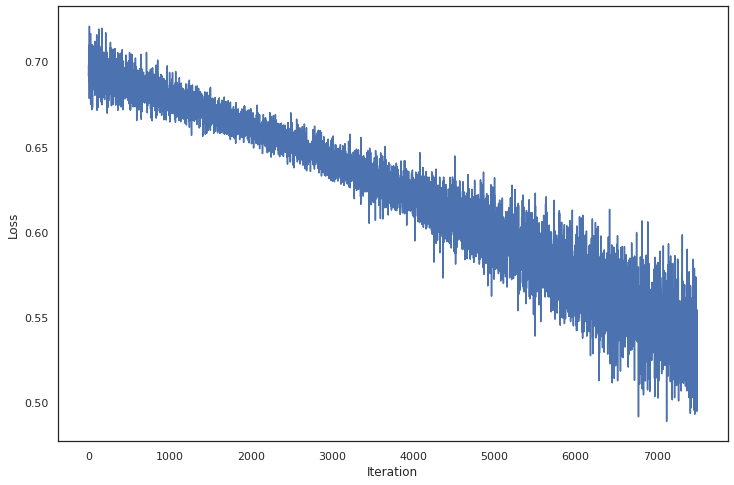

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

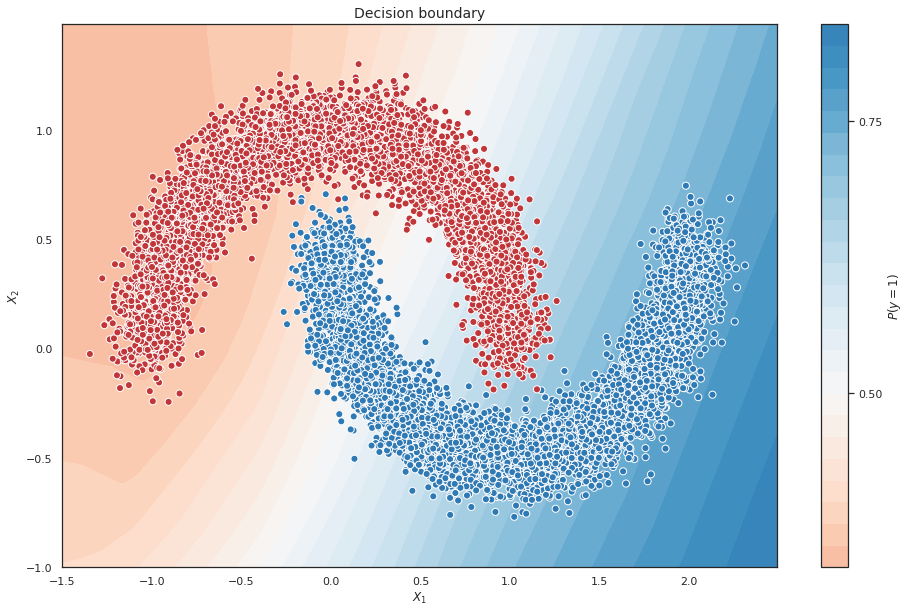

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.softmax(model(batch), dim=-1)[:, 1]
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

# Граф вычислений

Посмотрим на граф вычислений, который получился у нашей нейронной сети. 

In [ ]:
! pip install torchviz
# ! apt-get install graphviz 

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
model = nn.Sequential(
    nn.Linear(2, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 2)
)

X_batch, y_batch = next(iter(train_dl))
pred = model(X_batch)

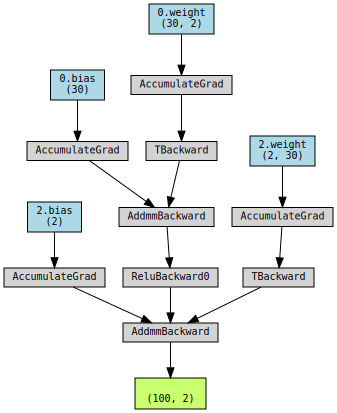

In [ ]:
from torchviz import make_dot
make_dot(pred, params=dict(model.named_parameters()))

Выглядит странно, нет входных данных, в чем проблема?

Мы начинаем следить за выходом операции только в случае, если хотя бы один вход требовал градиента. Чтобы показать, что для тензора нужно считать градиент и следить за операциями, которые его используют, нужно установить у него .requires_grad=True. 

Обычно нам никогда не нужно считать градиент лосса по входному тензору X_batch, потому что это не вес и помеенять его мы все равно не сможем. Но сейчас включим его, чтобы найти на графе.

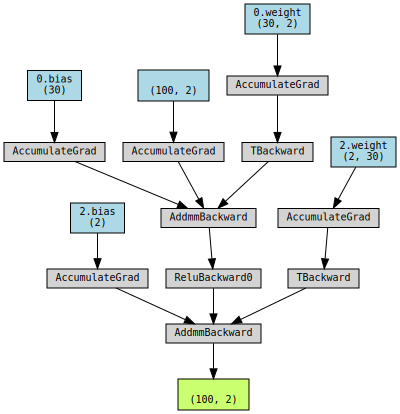

In [ ]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)
model = nn.Sequential(
    nn.Linear(2, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, 2)
)

X_batch, y_batch = next(iter(train_dl))
X_batch.requires_grad = True
pred = model(X_batch)
make_dot(pred, params=dict(model.named_parameters()))


# Что мы сегодня сделали?

* Написали полносвязную нейронную сеть для классификации точек.
* Выяснили, что из чего состоит обучение нейронной сети: данные, модель, лосс и оптимизатор.
* Узнали, как работает подсчет градиента в PyTorch, что такое граф вычислений и зачем он нужен.

# Что будет дальше?

* Обучение на TPU vs GPU vs CPU.
* Регуляризация нейросетей
* Варианты градиентного спуска.
* BatchNormalization, Dropout (optional)

# Дополнительные материалы

* Чтобы лучше понять PyTorch рекомендую туториал от DeepLearningSchool, который поможет вам лучше понять, как работать с PyTorch, если у вас уже есть навыки в numpy. https://colab.research.google.com/drive/10yot7fAI2EAHntV0hhZsEYDFo-nGdKGb?usp=sharing

* Существует очень хороший курс по нейронным сетям для программистов: https://course.fast.ai/. Он показывает как использовать нейронные сети с помозью своей собственной библиотеки fastai, которая строится над PyTorch. Очень качественный курс. На мой взгляд, единственный минус - привязанность к собственному фреймворку, который скрывает много тонкостей.

* Если вы уже знакомы с базовыми понятиями в нейронных сетях, то туториалы с официального сайта PyTorch подойдут вам. https://pytorch.org/tutorials/. Они сделаны очень качественно и часто используют самые новые и модные модели.

